<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/to_Uniform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [369]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import matplotlib.pyplot as plt


%matplotlib inline
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Data shape (1797, 64)


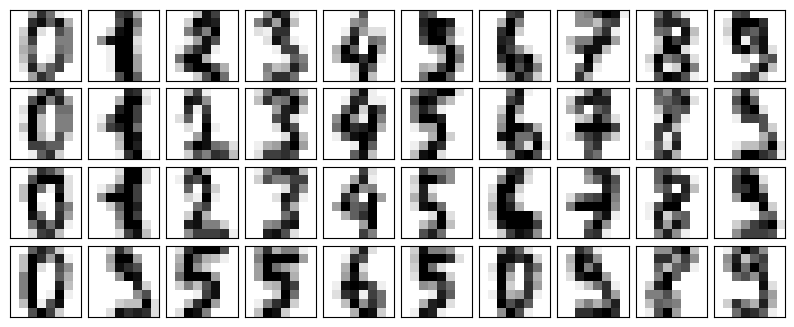

In [370]:
from sklearn.datasets import load_digits


digits = load_digits()
X = digits.data
print('Data shape', X.shape)


def plot_digits(data, w=8):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(w, w),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))

plot_digits(digits.data)


In [371]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [372]:
class To_Uniform(torch.nn.Module):

    def __init__(self, input_dim, hidden_layer, output_dim):
        super(To_Uniform, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.output_dim = output_dim

        self.linear1 = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_layer),
            nn.Sigmoid(),
            nn.BatchNorm1d(self.hidden_layer)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(self.hidden_layer, self.hidden_layer),
            nn.Sigmoid(),
            nn.BatchNorm1d(self.hidden_layer)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(self.hidden_layer, self.hidden_layer),
            nn.Sigmoid(),
            nn.BatchNorm1d(self.hidden_layer)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(self.hidden_layer, self.hidden_layer),
            nn.Sigmoid(),
            nn.BatchNorm1d(self.hidden_layer)
        )
        self.linear5 = nn.Sequential(
            nn.Linear(self.hidden_layer, self.output_dim),
            nn.Sigmoid(),
            nn.BatchNorm1d(self.output_dim)
        )

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x

    def criterion(self, y, y_hat):
      return - nn.MSELoss()(y, y_hat)

In [373]:
X = digits.data
X = X.reshape(1797, 64)
X = (X - X.min()) / (X.max()-X.min())

X = Data(torch.from_numpy(X).type(torch.float32))
y = torch.from_numpy(digits.target).type(torch.float32)

In [374]:
model = To_Uniform(64, 512, 24)

In [375]:
train_loader = DataLoader(X, batch_size=500, shuffle=False)

In [376]:
epochs = 20
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)


COST = []

for epoch in range(epochs):
    total_loss = []

    x_ = X[:].type(torch.float32) + torch.normal(mean=0.0, std=0.00001, size=(X[:].shape[0], 64)).type(torch.float32)

    for index, x_batch in enumerate(train_loader, start=0):

        y_hat = model(x_[index*500: (index+1)*500])
        y_pred = model(x_batch)

        loss = model.criterion(y_pred, y_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  -2.061398107766621e-09
Epoch :  2   -----------> Loss :  -2.183323799531678e-09
Epoch :  3   -----------> Loss :  -2.3235587343073405e-09
Epoch :  4   -----------> Loss :  -2.494735085178945e-09
Epoch :  5   -----------> Loss :  -2.6903470007333397e-09
Epoch :  6   -----------> Loss :  -2.9620563224419527e-09
Epoch :  7   -----------> Loss :  -3.2722753950942263e-09
Epoch :  8   -----------> Loss :  -3.6021365890093193e-09
Epoch :  9   -----------> Loss :  -4.068926973133102e-09
Epoch :  10   -----------> Loss :  -4.5859928077263135e-09
Epoch :  11   -----------> Loss :  -5.46886480545794e-09
Epoch :  12   -----------> Loss :  -6.38676700415175e-09
Epoch :  13   -----------> Loss :  -7.105830479581243e-09
Epoch :  14   -----------> Loss :  -7.984257921478388e-09
Epoch :  15   -----------> Loss :  -8.63136984108337e-09
Epoch :  16   -----------> Loss :  -1.0104353576068092e-08
Epoch :  17   -----------> Loss :  -1.0564384034239538e-08
Epoch :  18   ----

In [377]:
Y = model(X[:])

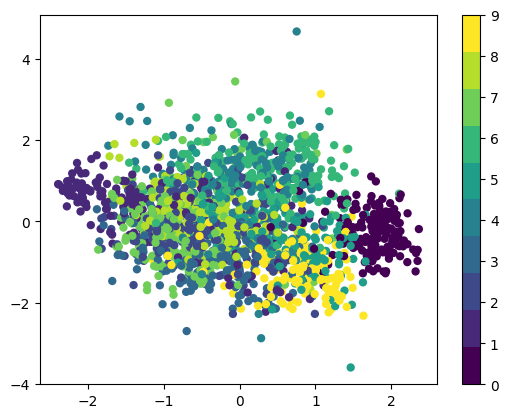

In [378]:
plt_1 = plt.scatter(Y[:,0].detach().numpy(), Y[:,1].detach().numpy(), c=digits.target, edgecolor='none',
            cmap=plt.get_cmap('viridis', 10))
plt.colorbar(plt_1)
plt.show()